In [1]:
import pickle
import numpy as np
import scvelo as scv
import torch
import scanpy as sc
from scipy.sparse import csr_matrix
from veloproj import *

scv.settings.verbosity = 1

In [10]:
parser = get_parser()
args = parser.parse_args(args=['--lr', '1e-5', 
                               '--n-epochs', '20000', 
                               '--g-rep-dim', '100',
                               '--k-dim', '100',
                               '--model-name', 'dentategyrus_model.cpt',
                               '--exp-name', 'CohAE_dentategyrus',
                               '--device', 'cuda:2',
                               '--gumbsoft_tau', '5',
                               '--nb_g_src', "X",
                               '--ld_nb_g_src', "X",
                               '--n_raw_gene', '2000',
                               '--n_conn_nb', '30',
                               '--n_nb_newadata', '30',
                               '--aux_weight', '1',
                               '--fit_offset_train', 'false',
                               '--fit_offset_pred', 'true',
                               '--use_offset_pred', 'false',
                               '--gnn_layer', 'GAT',
                               '--vis-key', 'X_umap',
                               '--vis_type_col', 'seurat_clusters',
                               '--scv_n_jobs', '10',
                              ])
args                              

Namespace(adata=None, aux_weight=1.0, conv_thred=1e-06, data_dir=None, device='cuda:2', exp_name='CohAE_dentategyrus', fit_offset_pred=True, fit_offset_train=False, g_rep_dim=100, gnn_layer='GAT', gumbsoft_tau=5.0, h_dim=256, is_half=False, k_dim=100, ld_adata='projection.h5', ld_nb_g_src='X', log_interval=100, lr=1e-05, lr_decay=0.9, mask_cluster_list=None, model_name='dentategyrus_model.cpt', n_conn_nb=30, n_epochs=20000, n_nb_newadata=30, n_raw_gene=2000, nb_g_src='X', output='./', refit=True, scv_n_jobs=10, seed=42, sl1_beta=1.0, use_norm=False, use_offset_pred=False, use_x=False, v_rg_wt=0.0, vis_key='X_umap', vis_type_col='seurat_clusters', weight_decay=0.0, z_dim=100)

In [3]:
torch.manual_seed(args.seed)
torch.cuda.manual_seed(args.seed)
np.random.seed(args.seed)
torch.backends.cudnn.deterministic = True

device = torch.device(args.device if args.device.startswith('cuda') and torch.cuda.is_available() else "cpu")

In [4]:
cluster_edges = [("OPC", "OL")]
EXP_NAME = args.exp_name
exp_metrics = {}

In [5]:
def main_AE(args, adata):
    spliced = adata.layers['Ms']
    unspliced = adata.layers['Mu']
    tensor_s = torch.FloatTensor(spliced).to(device)
    tensor_u = torch.FloatTensor(unspliced).to(device)
    tensor_x = torch.FloatTensor(adata.X.toarray()).to(device)
    #tensor_x = torch.FloatTensor(adata.X).to(device)
    tensor_v = torch.FloatTensor(adata.layers['stc_velocity']).to(device)

    model = init_model(adata, args, device)

    inputs = [tensor_s, tensor_u]
    xyids = [0, 1]
    if args.use_x:
        inputs.append(tensor_x)

    model = fit_model(args, adata, model, inputs, tensor_v, xyids, device)
    return tensor_s, tensor_u, tensor_x  

In [8]:
adata = sc.read_h5ad('/home/linxy29/holab/linxy/vivian/seuratObj/ncc_seurat.h5ad')
scv.pp.neighbors(adata, n_neighbors=30, n_pcs=15)
scv.utils.show_proportions(adata)
scv.pp.filter_and_normalize(adata, min_shared_counts=30, n_top_genes=args.n_raw_gene)
scv.pp.moments(adata, n_pcs=15, n_neighbors=30)
print(adata)
, basis='X_umap', color='seurat_clusters'

Abundance of ['spliced', 'unspliced']: [0.62 0.38]
AnnData object with n_obs × n_vars = 7357 × 1785
    obs: 'Clusters', '_X', '_Y', 'batch', 'seurat_clusters', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    uns: 'pca', 'neighbors'
    obsm: 'X_umap', 'X_pca'
    varm: 'PCs'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced', 'Ms', 'Mu'
    obsp: 'distances', 'connectivities'


  0%|          | 0/7357 [00:00<?, ?cells/s]

saving figure to file ./figures/scvelo_ncc_scVelo.png


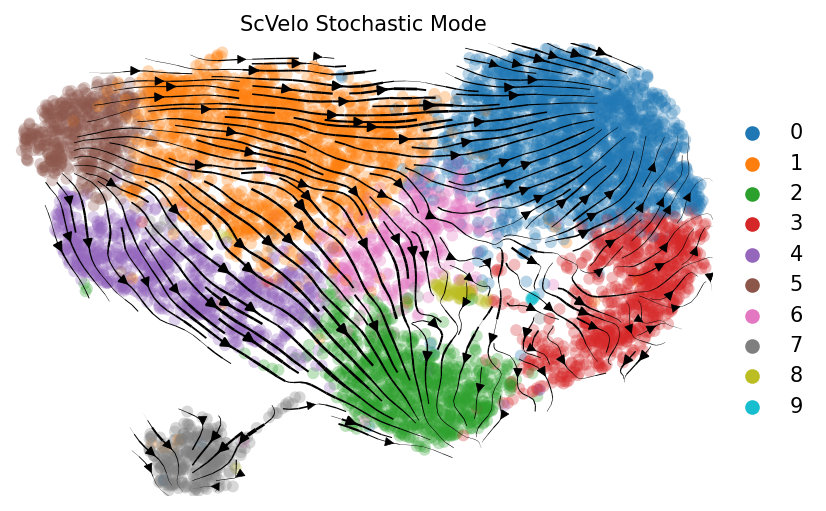

# Cross-Boundary Transition Score (A->B)
{}
Total Mean: nan
# Cross-Boundary Velocity Coherence (A->B)
{}
Total Mean: nan
# Cross-Boundary Direction Correctness (A->B)
{}
Total Mean: nan
# In-cluster Coherence
{'0': 0.7435839, '1': 0.7419233, '2': 0.74003255, '3': 0.7547312, '4': 0.7414096, '5': 0.7689659, '6': 0.76630527, '7': 0.8215762, '8': 0.8448309, '9': 0.84130204}
Total Mean: 0.7764660716056824
# In-cluster Confidence
{'0': 0.6121483043385372, '1': 0.5898818542408276, '2': 0.6396605730698036, '3': 0.5646911132805453, '4': 0.5966558164350458, '5': 0.5764701988922774, '6': 0.5932808065350165, '7': 0.6327422031918047, '8': 0.635284667627679, '9': 0.642570860683918}
Total Mean: 0.6083386398295455


AnnData object with n_obs × n_vars = 7357 × 1785
    obs: 'Clusters', '_X', '_Y', 'batch', 'seurat_clusters', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts', 'stc_velocity_self_transition', 'stc_velocity_length', 'stc_velocity_confidence', 'stc_velocity_confidence_transition'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'stc_velocity_gamma', 'stc_velocity_qreg_ratio', 'stc_velocity_r2', 'stc_velocity_genes'
    uns: 'pca', 'neighbors', 'stc_velocity_params', 'stc_velocity_graph', 'stc_velocity_graph_neg', 'seurat_clusters_colors'
    obsm: 'X_umap', 'X_pca', 'stc_velocity_umap'
    varm: 'PCs'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced', 'Ms', 'Mu', 'stc_velocity', 'variance_stc_velocity'
    obsp: 'distances', 'connectivities'

In [11]:
scv.tl.velocity(adata, vkey='stc_velocity', mode="stochastic")
scv.tl.velocity_graph(adata, vkey='stc_velocity', n_jobs=args.scv_n_jobs)
scv.tl.velocity_confidence(adata, vkey='stc_velocity')
scv.pl.velocity_embedding_stream(adata,  legend_loc="right margin", vkey="stc_velocity", basis=args.vis_key, color=args.vis_type_col,
                                 dpi=150, title='ScVelo Stochastic Mode', save = 'ncc_scVelo.png')
exp_metrics["stc_mode"] = evaluate(adata, cluster_edges, args.vis_type_col, "stc_velocity")
adata

In [31]:
adata.X = csr_matrix(adata.X)
adata

AnnData object with n_obs × n_vars = 2535 × 2252
    obs: 'Clusters', '_X', '_Y', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'leiden', 'stc_velocity_self_transition', 'stc_velocity_length', 'stc_velocity_confidence', 'stc_velocity_confidence_transition', 'velocity_self_transition'
    var: 'gene_ids', 'feature_types', 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'velocity_gamma', 'velocity_qreg_ratio', 'velocity_r2', 'velocity_genes', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std', 'stc_velocity_gamma', 'stc_velocity_qreg_ratio', 'stc_velocity_r2', 'stc_velocity_genes', 'fit_alpha', 'fit_beta', 'fit_gamma', 'fit_t_', 'fit_scaling', 'fit_std_u', 'fit_std_s', 'fit_likelihood', 'fit_u0', 'fit_s0', 'fit_pval_steady', 'fit_steady_u', 'fit_stead

Loss: (Total) 0.053524, (AE) 0.052974, (LR) 1.00 * 0.000549: 100%|██████████| 20000/20000 [20:10<00:00, 16.52it/s]


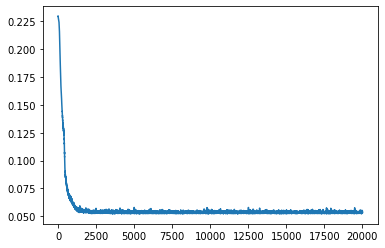

In [12]:
tensor_s, tensor_u, tensor_x = main_AE(args, adata)

  0%|          | 0/7357 [00:00<?, ?cells/s]

saving figure to file ./figures/scvelo_dentategyrus_pojection.png


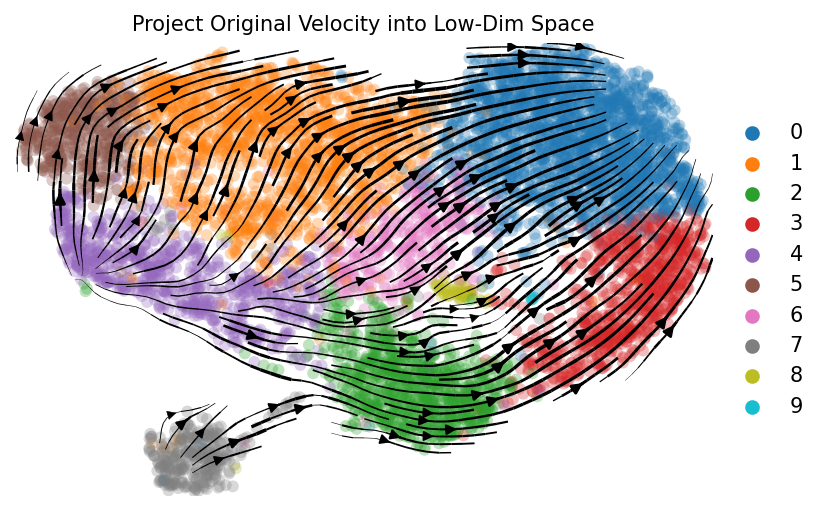

# Cross-Boundary Transition Score (A->B)
{}
Total Mean: nan
# Cross-Boundary Velocity Coherence (A->B)
{}
Total Mean: nan
# Cross-Boundary Direction Correctness (A->B)
{}
Total Mean: nan
# In-cluster Coherence
{'0': 0.99997324, '1': 0.99996716, '2': 0.9999706, '3': 0.999966, '4': 0.99997735, '5': 0.99996495, '6': 0.99997294, '7': 0.9999754, '8': 0.999989, '9': 0.9999924}
Total Mean: 0.9999748468399048
# In-cluster Confidence
{'0': 0.9999666532075961, '1': 0.9999622019723475, '2': 0.9999661752753728, '3': 0.9999543247845373, '4': 0.9999708399637458, '5': 0.9999566128738298, '6': 0.9999520916823107, '7': 0.9999665018182677, '8': 0.9999659351176686, '9': 0.9999477565288544}
Total Mean: 0.999960909322453


In [13]:
def exp(adata, exp_metrics):
    model = init_model(adata, args, device)
    model.load_state_dict(torch.load(args.model_name))
    model = model.to(device)
    model.eval()
    with torch.no_grad():
        
        spliced = adata.layers['Ms']
        unspliced = adata.layers['Mu']
        tensor_s = torch.FloatTensor(spliced).to(device)
        tensor_u = torch.FloatTensor(unspliced).to(device)
        tensor_x = torch.FloatTensor(adata.X.toarray()).to(device)

        x = model.encoder(tensor_x)
        s = model.encoder(tensor_s)
        u = model.encoder(tensor_u)
        
        v = estimate_ld_velocity(s, u, device=device, perc=[5, 95], 
                                 norm=args.use_norm, fit_offset=args.fit_offset_pred, 
                                 use_offset=args.use_offset_pred).cpu().numpy()
        x = x.cpu().numpy()
        s = s.cpu().numpy()
        u = u.cpu().numpy()
    
    adata = new_adata(adata, x, s, u, v, g_basis=args.ld_nb_g_src, n_nb_newadata=args.n_nb_newadata)
    scv.tl.velocity_graph(adata, vkey='new_velocity', n_jobs=args.scv_n_jobs)
    scv.pl.velocity_embedding_stream(adata, legend_loc='right_margin', vkey="new_velocity", basis=args.vis_key, color=[args.vis_type_col],
                                    title="Project Original Velocity into Low-Dim Space", smooth=0.5,
                                    dpi=150,
                                    save='dentategyrus_pojection.png')  
    scv.tl.velocity_confidence(adata, vkey='new_velocity')
    exp_metrics['Cohort AutoEncoder'] = evaluate(adata, cluster_edges, args.vis_type_col, "new_velocity")
exp(adata, exp_metrics)